Model: "Basic3dCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 157, 157, 6, 3)]  0         
_________________________________________________________________
conv3d (Conv3D)              (None, 157, 157, 6, 64)   5248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 78, 78, 3, 64)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 78, 3, 64)     256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 78, 78, 3, 128)    221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 39, 39, 1, 128)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 39, 1, 128)    5

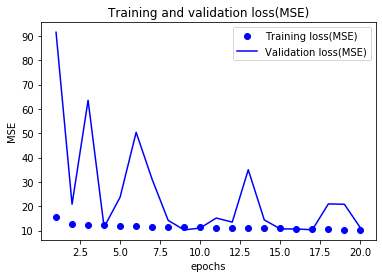

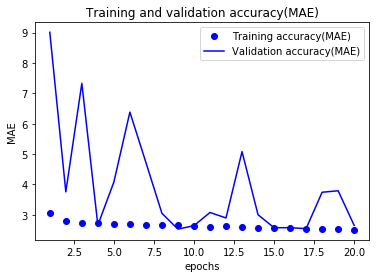

2.5016024112701416


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx]#.astype("float32")

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    #arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

x = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
y = get_windspeed('VOBL').reshape(-1, 1)

X = np.zeros((26275, 157, 157, 6, 3))
for i in range(26275):
    X[i,:,:,:,:] = np.rollaxis(x[i:i+6, :, :, :],0,3)
    
#Y = get_windspeed('VOBL')[5:].reshape(-1, 1)
Y = y[5:]

# splitting the data
train_features, train_labels = X[:18392], Y[:18392]
val_features, val_labels = (X[18392:22333], Y[18392:22333])
test_features, test_labels = (X[22333:], Y[22333:])

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

#initializer = tf.keras.initializers.HeUniform()
from tensorflow.keras import layers
inputs = keras.Input(shape=(157, 157, 6, 3))
x = layers.Conv3D(filters=64, kernel_size=(3,3,3), padding='same', activation="relu")(inputs)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters=128, kernel_size=(3,3,3), padding='same', activation="relu")(x)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic3dCNN")

print(model.summary())

opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss= "mse", optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "wVOBL_3D.keras",
                                         save_best_only = True, monitor = "val_loss")]
history = model.fit(train_features, train_labels, batch_size = 8, epochs=20, verbose=2, validation_data = (val_features, val_labels), callbacks = callbacks, use_multiprocessing=True)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

f1.savefig(f"wVOBL_3D1.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVOBL_3D2.jpg", bbox_inches='tight', dpi=600);
print(min(mae))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx]#.astype("float32")

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    #arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

x = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
y = get_windspeed('VOBL').reshape(-1, 1)

X = np.zeros((26275, 157, 157, 6, 3))
for i in range(26275):
    X[i,:,:,:,:] = np.rollaxis(x[i:i+6, :, :, :],0,3)
    
#Y = get_windspeed('VOBL')[5:].reshape(-1, 1)
Y = y[5:]
test_features, test_labels = (X[22333:], Y[22333:])

model = keras.models.load_model('wVOBL_3D.keras', compile = False)
#test_loss, test_mae = model.evaluate(test_features, test_labels)
#print(f"Test MAE: {test_mae:.3f}")

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

pred = model.predict(test_features)
error = pred - test_labels

import pandas as pd
print(error.shape)
error = np.reshape(error, (test_labels.shape[0],))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("windspeed21_22FINAL.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
x = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
y = get_windspeed('VIDP').reshape(-1, 1)

X = np.zeros((8731, 157, 157, 6, 3))
for i in range(8731):
    X[i,:,:,:,:] = np.rollaxis(x[i:i+6, :, :, :],0,3)
    
#Y = get_windspeed('VOBL')[5:].reshape(-1, 1)
Y = y[5:]

X_test = X
Y_test = Y

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

test_features = X_test
test_labels = Y_test

model = keras.models.load_model('wVOBL_3D.keras', compile = False)
pred = model.predict(test_features)
error = pred - test_labels

remove_idx = []
for i, j in enumerate(list(test_labels)):
    if j == 0.0:
        remove_idx.append(i)
        
test_labels2 = np.reshape(test_labels, (8731,))
pred2 = np.reshape(pred, (8731,))
test_labels2 = np.delete(test_labels2, remove_idx)
pred2 = np.delete(pred2, remove_idx)
error0 = pred2 - test_labels2
percent_error = (error0/test_labels2)*100

pearson_matrix = np.corrcoef(test_labels2, pred2)
print(pearson_matrix)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
#plt.plot(range(24*90), test_labels[:24*90], label = "observation")
#plt.plot(range(24*90), pred[:24*90], label = "prediction")
plt.plot(range(24*90), test_labels[24*90:24*2*90], label = "observation")
plt.plot(range(24*90), pred[24*90:24*2*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*2*90:24*3*90], label = "observation")
#plt.plot(range(24*90), pred[24*2*90:24*3*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*3*90:24*4*90], label = "observation")
#plt.plot(range(24*90), pred[24*3*90:24*4*90], label = "prediction")
plt.title("observation vs prediction for the monsoon season")
plt.legend()
plt.xlabel("Hour since first june 00:00 in UTC")
plt.ylabel("windspeed (miles/hr)")
plt.show();

import pandas as pd
print(error.shape)
error = np.reshape(error, (8731,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import pandas as pd
print(percent_error.shape)
#error = np.reshape(percent_error, (8736-1205,))
#print(error.shape)
y = pd.Series(percent_error)
print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("percentage error ((error/observation)*100)")
plt.show();

#plot for summer
import pandas as pd
summer_err = error[:2184]
monsoon_err = error[2184:2*2184]
autumn_err = error[2*2184:3*2184]
winter_err = error[3*2184:]
error1 = np.reshape(summer_err, (2184,))
print(error1.shape)
x = pd.Series(error1)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for monsoon
error2 = np.reshape(monsoon_err, (2184,))
print(error2.shape)
x = pd.Series(error2)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for autumn
error3 = np.reshape(autumn_err, (2184,))
print(error3.shape)
x = pd.Series(error3)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for winter
error4 = np.reshape(winter_err, (2184,))
print(error4.shape)
x = pd.Series(error4)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

Model: "Basic3dCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 157, 157, 6, 3)]  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 157, 157, 6, 64)   5248      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 78, 78, 3, 64)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 78, 78, 3, 64)     256       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 78, 78, 3, 128)    221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 39, 39, 1, 128)    0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 39, 39, 1, 128)    5

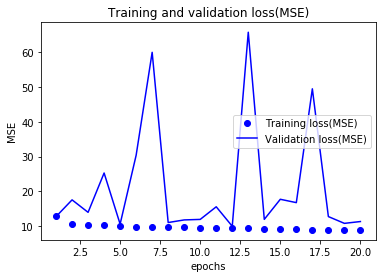

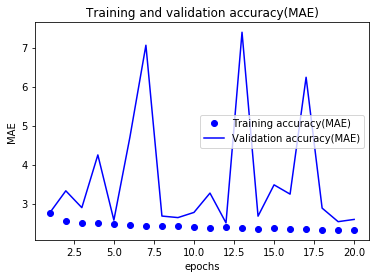

2.325139284133911


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx]#.astype("float32")

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    #arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

x = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
y = get_windspeed('VABB').reshape(-1, 1)

X = np.zeros((26275, 157, 157, 6, 3))
for i in range(26275):
    X[i,:,:,:,:] = np.rollaxis(x[i:i+6, :, :, :],0,3)
    
#Y = get_windspeed('VOBL')[5:].reshape(-1, 1)
Y = y[5:]

# splitting the data
train_features, train_labels = X[:18392], Y[:18392]
val_features, val_labels = (X[18392:22333], Y[18392:22333])
test_features, test_labels = (X[22333:], Y[22333:])

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

#initializer = tf.keras.initializers.HeUniform()
from tensorflow.keras import layers
inputs = keras.Input(shape=(157, 157, 6, 3))
x = layers.Conv3D(filters=64, kernel_size=(3,3,3), padding='same', activation="relu")(inputs)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters=128, kernel_size=(3,3,3), padding='same', activation="relu")(x)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic3dCNN")

print(model.summary())

opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss= "mse", optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "wVABB_3D.keras",
                                         save_best_only = True, monitor = "val_loss")]
history = model.fit(train_features, train_labels, batch_size = 8, epochs=20, verbose=2, validation_data = (val_features, val_labels), callbacks = callbacks, use_multiprocessing=True)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

f1.savefig(f"wVABB_3D1.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVABB_3D2.jpg", bbox_inches='tight', dpi=600);
print(min(mae))

Model: "Basic3dCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 157, 157, 6, 3)]  0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 157, 157, 6, 64)   5248      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 78, 78, 3, 64)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 78, 78, 3, 64)     256       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 78, 78, 3, 128)    221312    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 39, 39, 1, 128)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 39, 39, 1, 128)    5

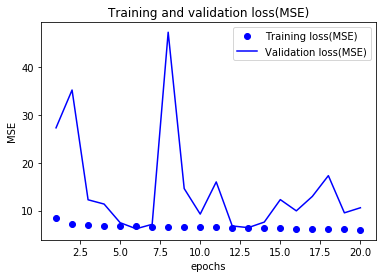

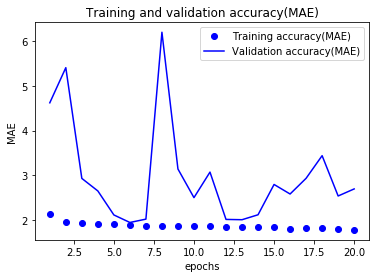

1.78218412399292


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx].astype("float32")

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

x = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
y = get_windspeed('VOTV').reshape(-1, 1)

X = np.zeros((26275, 157, 157, 6, 3))
for i in range(26275):
    X[i,:,:,:,:] = np.rollaxis(x[i:i+6, :, :, :],0,3)
    
#Y = get_windspeed('VOBL')[5:].reshape(-1, 1)
Y = y[5:]

# splitting the data
train_features, train_labels = X[:18392], Y[:18392]
val_features, val_labels = (X[18392:22333], Y[18392:22333])
test_features, test_labels = (X[22333:], Y[22333:])

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

#initializer = tf.keras.initializers.HeUniform()
from tensorflow.keras import layers
inputs = keras.Input(shape=(157, 157, 6, 3))
x = layers.Conv3D(filters=64, kernel_size=(3,3,3), padding='same', activation="relu")(inputs)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters=128, kernel_size=(3,3,3), padding='same', activation="relu")(x)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic3dCNN")

print(model.summary())

opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss= "mse", optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "wVOTV_3D.keras",
                                         save_best_only = True, monitor = "val_loss")]
history = model.fit(train_features, train_labels, batch_size = 8, epochs=20, verbose=2, validation_data = (val_features, val_labels), callbacks = callbacks, use_multiprocessing=True)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

f1.savefig(f"wVOTV_3D1.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVOTV_3D2.jpg", bbox_inches='tight', dpi=600);
print(min(mae))

Model: "Basic3dCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 157, 157, 6, 3)]  0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 157, 157, 6, 64)   5248      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 78, 78, 3, 64)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 78, 78, 3, 64)     256       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 78, 78, 3, 128)    221312    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 39, 39, 1, 128)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 39, 39, 1, 128)    5

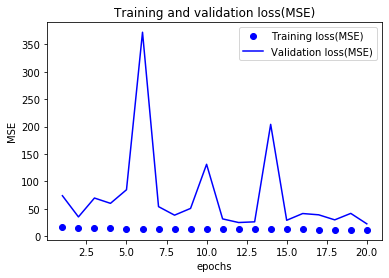

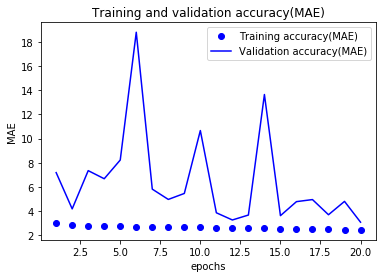

2.447819232940674


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx]#.astype("float32")

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    #arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

x = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
y = get_windspeed('VECC').reshape(-1, 1)

X = np.zeros((26275, 157, 157, 6, 3))
for i in range(26275):
    X[i,:,:,:,:] = np.rollaxis(x[i:i+6, :, :, :],0,3)
    
#Y = get_windspeed('VOBL')[5:].reshape(-1, 1)
Y = y[5:]

# splitting the data
train_features, train_labels = X[:18392], Y[:18392]
val_features, val_labels = (X[18392:22333], Y[18392:22333])
test_features, test_labels = (X[22333:], Y[22333:])

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

#initializer = tf.keras.initializers.HeUniform()
from tensorflow.keras import layers
inputs = keras.Input(shape=(157, 157, 6, 3))
x = layers.Conv3D(filters=64, kernel_size=(3,3,3), padding='same', activation="relu")(inputs)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters=128, kernel_size=(3,3,3), padding='same', activation="relu")(x)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic3dCNN")

print(model.summary())

opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss= "mse", optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "wVECC_3D.keras",
                                         save_best_only = True, monitor = "val_loss")]
history = model.fit(train_features, train_labels, batch_size = 8, epochs=20, verbose=2, validation_data = (val_features, val_labels), callbacks = callbacks, use_multiprocessing=True)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

f1.savefig(f"wVECC_3D1.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVECC_3D2.jpg", bbox_inches='tight', dpi=600);
print(min(mae))

Model: "Basic3dCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 157, 157, 6, 3)]  0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 157, 157, 6, 64)   5248      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 78, 78, 3, 64)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 78, 78, 3, 64)     256       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 78, 78, 3, 128)    221312    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 39, 39, 1, 128)    0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 39, 39, 1, 128)    5

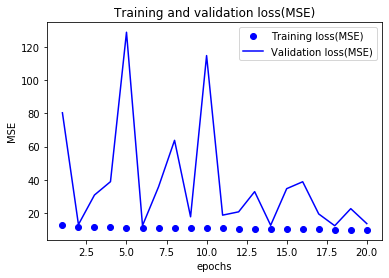

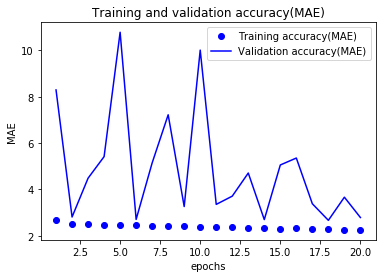

2.2512004375457764


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx]#.astype("float32")

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    #arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

x = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
y = get_windspeed('VIDP').reshape(-1, 1)

X = np.zeros((26275, 157, 157, 6, 3))
for i in range(26275):
    X[i,:,:,:,:] = np.rollaxis(x[i:i+6, :, :, :],0,3)
    
#Y = get_windspeed('VOBL')[5:].reshape(-1, 1)
Y = y[5:]

# splitting the data
train_features, train_labels = X[:18392], Y[:18392]
val_features, val_labels = (X[18392:22333], Y[18392:22333])
test_features, test_labels = (X[22333:], Y[22333:])

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

#initializer = tf.keras.initializers.HeUniform()
from tensorflow.keras import layers
inputs = keras.Input(shape=(157, 157, 6, 3))
x = layers.Conv3D(filters=64, kernel_size=(3,3,3), padding='same', activation="relu")(inputs)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters=128, kernel_size=(3,3,3), padding='same', activation="relu")(x)
x = layers.MaxPooling3D(pool_size=(2,2,2), strides=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic3dCNN")

print(model.summary())

opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss= "mse", optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "wVIDP_3D.keras",
                                         save_best_only = True, monitor = "val_loss")]
history = model.fit(train_features, train_labels, batch_size = 8, epochs=20, verbose=2, validation_data = (val_features, val_labels), callbacks = callbacks, use_multiprocessing=True)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

f1.savefig(f"wVIDP_3D1.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVIDP_3D2.jpg", bbox_inches='tight', dpi=600);
print(min(mae))